# 204.3. Astrometric Calibration

<div>
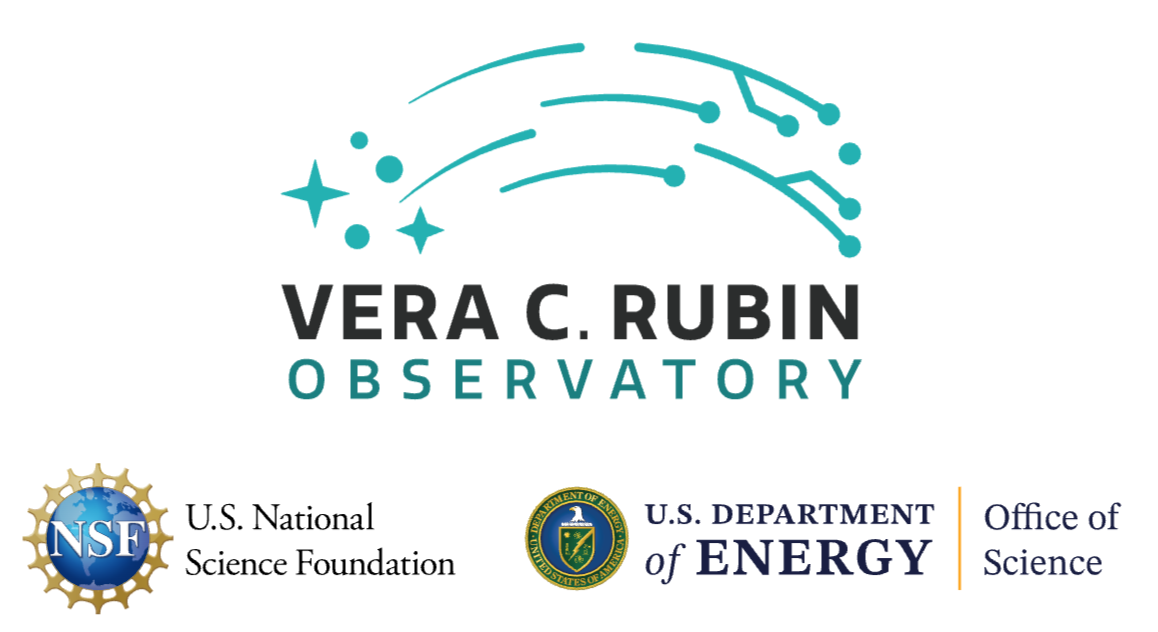
</div>
For the Rubin Science Platform at data.lsst.cloud. <br>
Data Release: <a href="http://dp1.lsst.io">Data Preview 1</a> <br>
Container Size: large <br>
LSST Science Pipelines version: r29.1.1 <br>
Last verified to run: 2025-06-20 <br>
Repository: <a href="https://github.com/lsst/tutorial-notebooks">github.com/lsst/tutorial-notebooks</a> <br>

**Learning objective:** To understand the astrometric calibrations.

**LSST data products:** `visit_image`, `deep_coadd`

**Packages:** `lsst.daf.butler`, `lsst.geom`, `lsst.rsp`

**Credit:**
Originally developed by Andrés A. Plazas Malagón and the Rubin Community Science team with input from Clare Saunders, Jim Bosh, and Pierre-François Leget. Please consider acknowledging them if this notebook is used for the preparation of journal articles, software releases, or other notebooks.

**Get Support:**
Everyone is encouraged to ask questions or raise issues in the 
<a href="https://community.lsst.org/c/support">Support Category</a> 
of the Rubin Community Forum.
Rubin staff will respond to all questions posted there.

## 1. Introduction

The World Coordinate System (WCS), or astrometric solution, defines how pixel positions in an image map to celestial coordinates—right ascension and declination (RA, Dec).

The LSST Science Pipelines perform astrometric calibration in two main stages. 

1. An initial WCS is estimated using a static camera model and refined per detector and exposure by matching sources to [Gaia DR3](https://ui.adsabs.harvard.edu/abs/2023A&A...674A...1G/abstract), achieving an accuracy of approximately 10-20 milliarcseconds—sufficient for associating sources across visits.
2. A more precise solution is derived using overlapping visits with the `GBDES` ([Bernstein, Armstrong, Plazas et al., 2017](https://ui.adsabs.harvard.edu/abs/2017PASP..129g4503B/abstract)) algorithm. This model fits two components: a per-detector static map (capturing camera distortions and the physical layout of the camera) and a per-visit dynamic map (accounting for time-varying effects like atmospheric refraction). The solution minimizes positional differences between matched stars and Gaia references, and can optionally include proper motion, parallax, and corrections for differential chromatic refraction (DCR).

Ongoing work aims to better account for atmospheric turbulence, detector-level systematics, and long-term camera evolution, with plans to extend astrometric calibration from isolated calibration stars to the full LSST object catalog.

**References**
* [Data Management Technical Note - 266: Astrometric Calibration in the LSST
Pipeline](https://dmtn-266.lsst.io/DMTN-266.pdf)
* [PSTN-019: The LSST Science Pipelines Software: Optical Survey Pipeline Reduction and Analysis Environment](https://pstn-019.lsst.io/)
* [RTN-095: The Vera C. Rubin Observatory Data Preview 1](https://rtn-095.lsst.io/)
* [AST: A library for modeling and manipulating coordinate systems](https://ui.adsabs.harvard.edu/abs/2016A%26C....15...33B/abstract)

**Related tutorials:**  The Monster reference catalog is covered in another tutorial in this series (200).

### 1.1. Import packages

Import `numpy`, a fundamental package for scientific computing with arrays in Python
(<a href="https://numpy.org">numpy.org</a>), and
`matplotlib`, a comprehensive library for data visualization
(<a href="https://matplotlib.org/">matplotlib.org</a>; 
<a href="https://matplotlib.org/stable/gallery/index.html">matplotlib gallery</a>).

From the `lsst` package, import modules for plotting, accessing the butler and the TAP service, and geometry utilities from the LSST Science Pipelines (<a href="https://pipelines.lsst.io/">pipelines.lsst.io</a>).

In [1]:
import lsst.daf.butler as dafButler
from lsst.rsp import get_tap_service
import lsst.geom
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from lsst.utils.plotting import (get_multiband_plot_colors,
                                 get_multiband_plot_linestyles)

### 1.2. Define parameters and functions

Instantiate the butler.

In [2]:
butler = dafButler.Butler("dp1", collections="LSSTComCam/DP1")
assert butler is not None

Instantiate the TAP service.

In [3]:
rsp_tap = get_tap_service("tap")
assert rsp_tap is not None

Get standard colors and linestyles

In [4]:
filter_colors = get_multiband_plot_colors()
filter_linestyles = get_multiband_plot_linestyles()

## 2. WCS for a visit image

The `visit_image` `WCS` is the most accurate pixel-to-sky transformation available for single-visit data. It is computed by fitting observed star positions to a reference catalog (e.g., "The Monster" reference catalog which includes Gaia stars), accounting for both telescope pointing and optical distortions. 

Define a particular location on the sky and a band. Use the center of the Extented Chandra Deep Field South, in degrees.

In [5]:
ra_cen, dec_cen = 53.13, -28.10
my_band = 'i'

Get one `visit_image` around that location and band.

In [6]:
query = """visit.region OVERLAPS POINT(:ra, :dec) and band = :band"""
bind = {'ra': ra_cen, 'dec': dec_cen, 'band': my_band}
visitimage_refs = butler.query_datasets('visit_image',
                                        where=query,
                                        bind=bind,
                                        order_by=['detector'],
                                        with_dimension_records=True,
                                        limit=1)

Inspect the information about the visit image.

In [7]:
print(visitimage_refs)

[DatasetRef(DatasetType('visit_image', {band, instrument, day_obs, detector, physical_filter, visit}, ExposureF), {instrument: 'LSSTComCam', detector: 0, visit: 2024110800245, band: 'i', day_obs: 20241108, physical_filter: 'i_06'}, run='LSSTComCam/runs/DRP/DP1/DM-51335', id=1e1cd322-4ddd-4918-b2ac-c38e94fc8af5)]


In [8]:
visit_image = butler.get(visitimage_refs[0])

Get the WCS object.

In [15]:
wcs = visit_image.getWcs()

### 2.1. Pixel scale at a particular point.

Use the bounding box (`bbox`) information for the `visit_image` to get the pixel scale, in arcseconds, at the center of the detector.
The pixel scale can be calculated at different points, and it may differ across the focal plane.

>  **Warning**: It is not recommended to call `wcs.getPixelScale()` without an argument, as the point that it implicitly uses as a reference might not be relevant for the case at hand. 

In [20]:
bbox = visit_image.getBBox()

In [21]:
wcs.getPixelScale(lsst.geom.Point2D(
    bbox.centerX, bbox.centerY)).asArcseconds()

0.20034255528302644

>  **Warning**: The `visit_image` WCS has a `getFitsMetadata()` method that returns metadata information. For a `visit_image`, this metadata should not be used to reconstruct a WCS (e.g., with `astropy`) for precision astrometric analysis, as it only provides an approximation to the full WCS.

Clean up.

In [23]:
del query, bind, visitimage_refs
del visit_image, wcs, bbox

## 3. WCS from a coadd image

Query the butler for an *i*-band `deep_coadd` image that is near the center of the ECDS field.

In [24]:
center_coadd_datasetrefs = butler.query_datasets("deep_coadd",
                                                 where=f"band.name='{my_band}' AND\
                                                 patch.region OVERLAPS POINT(ra, dec)",
                                                 bind={"ra": ra_cen, "dec": dec_cen},
                                                 with_dimension_records=True,
                                                 order_by=["patch.tract"])

In [25]:
center_coadd_datasetrefs

[DatasetRef(DatasetType('deep_coadd', {band, skymap, tract, patch}, ExposureF), {band: 'i', skymap: 'lsst_cells_v1', tract: 5063, patch: 14}, run='LSSTComCam/runs/DRP/DP1/DM-51335', id=63cf9a40-44ce-40d8-b1a9-827f236c3a8a)]

Retrieve the deep coadd image from the butler.

In [26]:
coadd = butler.get(center_coadd_datasetrefs[0])

Get the WCS.

In [27]:
wcs_coadd = coadd.getWcs()

### 3.1. Convert pixel to sky coordinates

The WCS methods `pixelToSky` and `pixelToSkyArray` can convert pixels to sky coordinates. The latter is faster.

> **Warning**: The arguments passed to `pixelToSkyArry` must be double-precision floats, to avoid call errors.

In [28]:
wcs_coadd.pixelToSkyArray(300.4, 5000.6)

(array([0.94270351]), array([-0.48996641]))

> **Warning**: A `WCS` object can also be obtained from `raw` images. However, it is a rough estimate based on where the telescope _thought_ it was pointing. It does not account for distortions or actual star positions and is only intended for internal use during initial processing. It should not be used for scientific measurements.

Clean up.

In [29]:
del center_coadd_datasetrefs
del coadd, wcs_coadd

## 4. Sky coordinates, errors, and astrometric accuracy

In the `source` and `object` catalogs, centroids are measured using the `SdssCentroid` algorithm, which applies a Gaussian weight function initially matched to the PSF size and then increases it by factors of two to match the weighted size of the object. 

This algorithm operates entirely in pixel coordinates, not sky coordinates. Once the centroid and its uncertainty are determined in pixels, the WCS is used to transform these measurements into right ascension and declination. The uncertainties in RA and Dec are derived by propagating the pixel-level errors through this transformation. 

### 4.1.  Centroid uncertainties

Use the TAP service to retrieve from the `object` table the centroid uncertainties and magnitudes for PSF stars used in modeling.

In [30]:
radius = 2.0

In [31]:
query = (
    "SELECT objectId, "
    f"{my_band}_raErr, {my_band}_decErr, "
    "refExtendedness, "
    f"scisql_nanojanskyToAbMag({my_band}_psfFlux) as"
    f" {my_band}_psfmag, "
    f"{my_band}_calib_psf_used, "
    f"{my_band}_pixelFlags_inexact_psfCenter, "
    f"{my_band}_calibFlux "
    "FROM dp1.Object "
    "WHERE refExtendedness = 0.0 "
    f"AND {my_band}_calib_psf_used = 1 "
    f"AND {my_band}_pixelFlags_inexact_psfCenter = 0 "
    f"AND {my_band}_calibFlux > 360 "
    "AND CONTAINS(POINT('ICRS', coord_ra, coord_dec), "
    f"CIRCLE('ICRS', {ra_cen}, {dec_cen}, {radius})) = 1 "
    "ORDER BY objectId"
)
print(query)

SELECT objectId, i_raErr, i_decErr, refExtendedness, scisql_nanojanskyToAbMag(i_psfFlux) as i_psfmag, i_calib_psf_used, i_pixelFlags_inexact_psfCenter, i_calibFlux FROM dp1.Object WHERE refExtendedness = 0.0 AND i_calib_psf_used = 1 AND i_pixelFlags_inexact_psfCenter = 0 AND i_calibFlux > 360 AND CONTAINS(POINT('ICRS', coord_ra, coord_dec), CIRCLE('ICRS', 53.13, -28.1, 2.0)) = 1 ORDER BY objectId


In [32]:
job = rsp_tap.submit_job(query)
job.run()
job.wait(phases=['COMPLETED', 'ERROR'])
print('Job phase is', job.phase)
if job.phase == 'ERROR':
    job.raise_if_error()
assert job.phase == 'COMPLETED'
psf_used_table = job.fetch_result().to_table()

Job phase is COMPLETED


Plot the distribution of the propagated uncertainties on the centroids.
Convert the errors from degrees to miliarseconds.

In [33]:
ra_err = psf_used_table[f"{my_band}_raErr"].to(u.mas)
dec_err = psf_used_table[f"{my_band}_decErr"].to(u.mas)

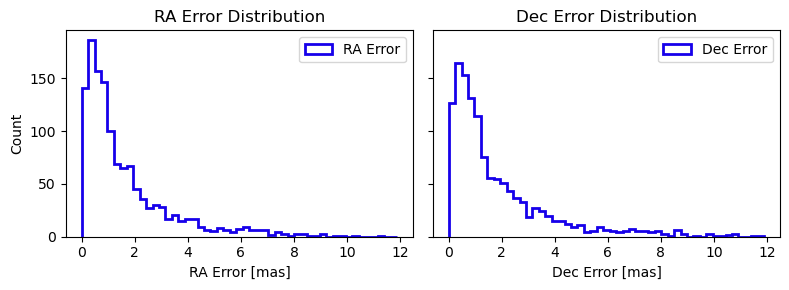

In [34]:
max_err = max(ra_err.max(), dec_err.max())
error_bins = np.linspace(0, max_err, 50)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3), sharey=True)

for ax, err, label in zip((ax1, ax2), (ra_err, dec_err), ('RA Error', 'Dec Error')):
    _, _, patches = ax.hist(err, bins=error_bins,
                            histtype='step',
                            linewidth=2,
                            color=filter_colors[my_band],
                            label=label)
    for patch in patches:
        patch.set_linestyle(filter_linestyles[my_band])
    ax.set_xlabel(f'{label} [mas]')
    ax.set_title(f'{label} Distribution')
    ax.legend()

ax1.set_ylabel('Count')
plt.tight_layout()
plt.show()

> **Figure 1:** Right Ascension and Declination `SdssCentroid` error distributions for a subset of stars used in PSF modeling from the `object` table.

### 4.2. Centroid error vs magnitude

Visualize the centroid error as a function of magnitude. The centroid error is proportional to the seeing and inversely proportional to the signal-to-noise ratio of each object.

Compute total centroid error in quadrature.

In [35]:
centroid_err = np.sqrt(ra_err**2 + dec_err**2)

Get the corresponding PSF magnitude.

In [36]:
mag = psf_used_table[f"{my_band}_psfmag"]

Display the centroid error as a functionn of magnitude.

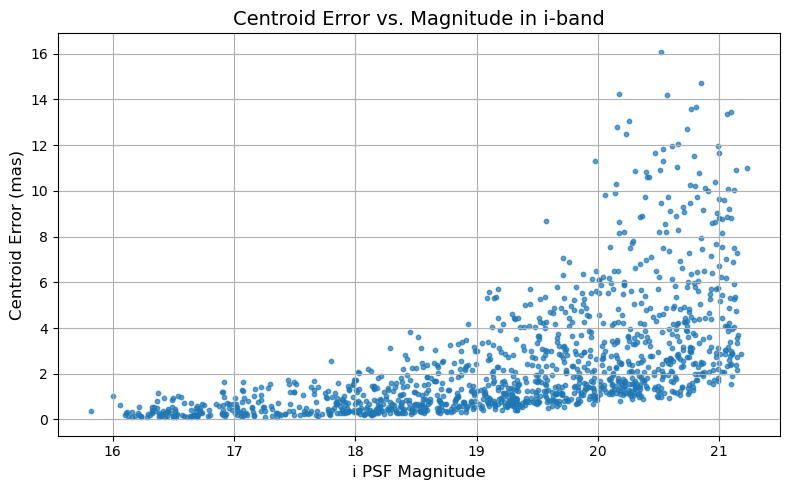

In [37]:
plt.figure(figsize=(8, 5))
plt.scatter(mag, centroid_err, s=10, alpha=0.7)
plt.xlabel(f"{my_band} PSF Magnitude", fontsize=12)
plt.ylabel("Centroid Error (mas)", fontsize=12)
plt.title(f"Centroid Error vs. Magnitude in {my_band}-band", fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()

> **Figure 2:** `SdssCentroid` errors as a function of *i*-band magnitude.

## 5. Notes on astrometric accuracy

The plots in Sections 4.1 and 4.2 use the propagated uncertainties on the centroids from the fit with the `SdssCentroid` algorithm, but they are not indicative of the overall astrometric accuracy. To assess the performance of the complete astrometric solution, internal and external consistency tests are performed.  

For **internal consistency**, the repeatability of position measurements for the same object (calculated as the RMS of the fit positions per object) shows a mean per-tract astrometric repeatability of approximately **10 milliarcseconds**. 

For **external consistency**, the median separation between sources *not* included in the astrometric fit and their associated counterparts in **Gaia DR3** is within **5 milliarcseconds**—well below the main survey’s design requirement of 50 milliarcseconds. Remaining residuals are due to distortions not yet included in the LSSTComCam astrometric model (but planned for future inclusion), such as **atmospheric**, **camera**, and **detector-level distortions**.  

For more details, see Section 5.3 on Astrometry in the [DP1 paper](https://rtn-095.lsst.io/).